Based on https://github.com/siyi-wind/TIP/tree/main/data/create_dvm_dataset.ipynb

In [1]:
import os
import torch
import operator
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from scipy.special import kl_div
from typing import Union, Tuple, Dict, Any
from scipy.spatial.distance import jensenshannon
from sklearn.model_selection import train_test_split

In [2]:
BASE = "/mnt/data/kgutjahr/datasets/DVM"
TABLES= os.path.join(BASE, "tables")
FEATURES = os.path.join(BASE, "images")
SHIFTED_DIR = os.path.join(BASE, "shifted_dists")

In [3]:
color_coding = {0: 'Beige',
                1: 'Black',
                2: 'Blue', 
                3: 'Bronze', 
                4: 'Brown', 
                5: 'Burgundy', 
                6: 'Gold', 
                7: 'Green', 
                8: 'Grey', 
                9: 'Indigo', 
                10: 'Magenta', 
                11: 'Maroon', 
                12: 'Multicolour', 
                13: 'Navy', 
                14: 'Orange', 
                15: 'Pink', 
                16: 'Purple', 
                17: 'Red', 
                18: 'Silver', 
                19: 'Turquoise', 
                20: 'White', 
                21: 'Yellow'}

In [4]:
def get_color_counts(df: pd.DataFrame) -> pd.DataFrame:
    color_counts = df["Color"].value_counts()
    color_percentages = df["Color"].value_counts(normalize=True) * 100

    # Optional: Combine into one DataFrame for clarity
    color_summary = pd.DataFrame({
        'Count': color_counts,
        'Percentage': color_percentages.round(3)
    })
    return color_summary

In [5]:
def plot_color_distributions(df: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 6))
    ax = df["Count"].plot(kind='bar', color='skyblue', edgecolor='black', width=1)

    # Customize the plot
    plt.title('Color distribution')
    plt.xlabel('Colors')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, fontsize=10)  # Rotate labels for better readability
    plt.tight_layout()

    # Show the plot
    plt.show()

In [6]:
def fill_missing_vals(df: pd.DataFrame, fill_values: list[str]) -> pd.DataFrame:
    # fill missing color with 0 if it isn't present in distribution
    for fill in fill_values:
        if fill not in df:
            df[fill] = 0
    return df

In [7]:
def calc_JS(first_dist: pd.DataFrame, second_dist: pd.DataFrame) -> float:
    js = jensenshannon(first_dist, second_dist)
    return float(js)

# Get color distribution of entire Dataset

In [8]:
physical_df = pd.read_csv(os.path.join(TABLES,'Ad_table_physical_filled_jittered_50.csv'))[['Adv_ID', 'Wheelbase','Height','Width','Length']]
physical_df

,Adv_ID,Wheelbase,Height,Width,Length
0,10_1$$1,3134.0,1534.0,2118.0,5387.0
1,10_1$$2,3102.0,1551.0,2075.0,5433.0
2,10_1$$3,3122.0,1490.0,2122.0,5369.0
3,10_1$$4,3135.0,1513.0,2094.0,5353.0
4,10_1$$5,3105.0,1514.0,2077.0,5376.0
...,...,...,...,...,...
268250,97_1$$1,NaN,NaN,NaN,NaN
268251,97_1$$2,NaN,NaN,NaN,NaN
268252,99_1$$1,NaN,NaN,NaN,NaN
268253,99_1$$2,NaN,NaN,NaN,NaN


In [9]:
ad_data = pd.read_csv(os.path.join(TABLES, 'Ad_table.csv'))[['Adv_ID', 'Genmodel', "Maker"]]
ad_data

/tmp/ipykernel_966584/3060315506.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  ad_data = pd.read_csv(os.path.join(TABLES, 'Ad_table.csv'))[['Adv_ID', 'Genmodel', "Maker"]]


,Adv_ID,Genmodel,Maker
0,10_1$$1,Arnage,Bentley
1,10_1$$2,Arnage,Bentley
2,10_1$$3,Arnage,Bentley
3,10_1$$4,Arnage,Bentley
4,10_1$$5,Arnage,Bentley
...,...,...,...
268250,97_1$$1,Sport,Westfield
268251,97_1$$2,Sport,Westfield
268252,99_1$$1,E10,Zenos
268253,99_1$$2,E10,Zenos


In [10]:
unique_cars = ad_data.drop_duplicates(subset=["Maker", "Genmodel"]).reset_index(drop=True)
unique_cars['Genmodel_ID'] = unique_cars['Adv_ID'].str.partition('$$')[0]
unique_cars['Car Name'] = unique_cars['Maker'].str.cat(unique_cars['Genmodel'], sep=' ')
unique_cars.drop(["Maker", "Genmodel", "Adv_ID"], axis=1, inplace=True)

unique_cars

,Genmodel_ID,Car Name
0,10_1,Bentley Arnage
1,10_2,Bentley Azure
2,10_3,Bentley Bentayga
3,10_4,Bentley Brooklands
4,10_5,Bentley Continental
...,...,...
911,96_7,Volvo V40
912,96_8,Volvo V40 Cross Country
913,96_9,Volvo V50
914,97_1,Westfield Sport


In [11]:
data_path = os.path.join(FEATURES, "data_df_unnorm.csv")
full_data_df = pd.read_csv(data_path)
full_data_df = full_data_df.loc[:, ~full_data_df.columns.str.contains('^Unnamed')]
full_data_df

,Adv_ID,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,Door_num,Entry_price,Engine_size,Color,Bodytype,Gearbox,Fuel_type,Genmodel_ID,Image_name,Predicted_viewpoint
0,10_1$$1,2018,4,2000.0,60000,21500,5.0,4.0,145000,6.8,Silver,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$Silver$$10_1$$1$$image_...,45
1,10_1$$13,2018,4,2000.0,53444,21995,5.0,4.0,145000,6.8,Silver,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$Silver$$10_1$$13$$image...,0
2,10_1$$16,2017,12,2000.0,49700,29500,5.0,4.0,145000,4.4,Blue,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$Blue$$10_1$$16$$image_1...,0
3,10_1$$18,2018,4,2000.0,75000,17995,5.0,4.0,145000,6.8,White,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$White$$10_1$$18$$image_...,90
4,10_1$$26,2017,5,2000.0,98000,17945,5.0,4.0,145000,6.8,Silver,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$Silver$$10_1$$26$$image...,225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183820,96_9$$353,2018,5,2004.0,100390,1999,5.0,5.0,17165,2.4,Silver,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45
183821,96_9$$374,2018,5,2004.0,149000,1450,5.0,5.0,17165,2.0,Silver,Estate,Manual,Diesel,96_9,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0
183822,96_9$$457,2018,5,2004.0,98167,3995,5.0,5.0,17165,2.4,Grey,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45
183823,96_9$$477,2018,2,2004.0,152230,1495,5.0,5.0,17165,1.8,Grey,Estate,Manual,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$477$$image_0.jpg,315


In [12]:
minimum_population = 100
values = (full_data_df.value_counts(subset=['Genmodel_ID'])>=minimum_population).values
codes = (full_data_df.value_counts(subset=['Genmodel_ID'])>=minimum_population).index
populated_codes = []
for i, v in enumerate(values):
  if v:
    populated_codes.append(codes[i][0])
    
full_data_df = full_data_df[full_data_df['Genmodel_ID'].isin(populated_codes)]

full_data_df

,Adv_ID,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,Door_num,Entry_price,Engine_size,Color,Bodytype,Gearbox,Fuel_type,Genmodel_ID,Image_name,Predicted_viewpoint
25,10_3$$1,2018,3,2016.0,12661,129990,5.0,5.0,135800,6.0,Grey,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...,225
26,10_3$$3,2018,4,2016.0,15141,135000,5.0,5.0,135800,6.0,Silver,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Silver$$10_3$$3$$imag...,225
27,10_3$$10,2018,6,2016.0,16526,127895,5.0,5.0,135800,6.0,Blue,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Blue$$10_3$$10$$image...,225
28,10_3$$11,2018,7,2016.0,16200,125995,5.0,5.0,135800,6.0,White,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$White$$10_3$$11$$imag...,0
29,10_3$$12,2018,6,2016.0,6000,145000,5.0,5.0,135800,6.0,Grey,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183820,96_9$$353,2018,5,2004.0,100390,1999,5.0,5.0,17165,2.4,Silver,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45
183821,96_9$$374,2018,5,2004.0,149000,1450,5.0,5.0,17165,2.0,Silver,Estate,Manual,Diesel,96_9,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0
183822,96_9$$457,2018,5,2004.0,98167,3995,5.0,5.0,17165,2.4,Grey,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45
183823,96_9$$477,2018,2,2004.0,152230,1495,5.0,5.0,17165,1.8,Grey,Estate,Manual,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$477$$image_0.jpg,315


In [13]:
full_data_df = full_data_df.merge(physical_df, on='Adv_ID')
full_data_df.dropna(inplace=True)
full_data_df

,Adv_ID,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,Door_num,Entry_price,Engine_size,...,Bodytype,Gearbox,Fuel_type,Genmodel_ID,Image_name,Predicted_viewpoint,Wheelbase,Height,Width,Length
0,10_3$$1,2018,3,2016.0,12661,129990,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...,225,2981.0,1746.0,2185.0,5123.0
1,10_3$$3,2018,4,2016.0,15141,135000,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Silver$$10_3$$3$$imag...,225,2953.0,1699.0,2268.0,5184.0
2,10_3$$10,2018,6,2016.0,16526,127895,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Blue$$10_3$$10$$image...,225,2974.0,1715.0,2257.0,5130.0
3,10_3$$11,2018,7,2016.0,16200,125995,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$White$$10_3$$11$$imag...,0,3031.0,1788.0,2184.0,5130.0
4,10_3$$12,2018,6,2016.0,6000,145000,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,0,3006.0,1727.0,2237.0,5154.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176409,96_9$$353,2018,5,2004.0,100390,1999,5.0,5.0,17165,2.4,...,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45,2591.0,1496.0,1762.0,4471.0
176410,96_9$$374,2018,5,2004.0,149000,1450,5.0,5.0,17165,2.0,...,Estate,Manual,Diesel,96_9,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0,2618.0,1449.0,1753.0,4536.0
176411,96_9$$457,2018,5,2004.0,98167,3995,5.0,5.0,17165,2.4,...,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45,2627.0,1467.0,1722.0,4509.0
176412,96_9$$477,2018,2,2004.0,152230,1495,5.0,5.0,17165,1.8,...,Estate,Manual,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$477$$image_0.jpg,315,2673.0,1457.0,1767.0,4512.0


## Plot Color Distribution of splits

In [14]:
def plot_compare_distribution(train_dist: Union[pd.Series, pd.DataFrame], val_dist: Union[pd.Series, pd.DataFrame], test_dist: Union[pd.Series, pd.DataFrame], feature: list[Any]) -> None:
    plt.figure(figsize=(12, 6))
    plt.plot(feature, train_dist.reindex(feature), label='Train', marker='o')
    plt.plot(feature, val_dist.reindex(feature), label='Validation', marker='s')
    plt.plot(feature, test_dist.reindex(feature), label='Test', marker='^')
    plt.xticks(rotation=45)
    plt.ylabel('Relative Frequency')
    plt.title('Color Distribution Comparison')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
colors = list(color_coding.values())

# Create datasets that contain distribution shifts

In [16]:
def data_split(df: pd.DataFrame, nclasses: int, split: float) -> np.ndarray:
  critical_ids = df.groupby('Genmodel_ID', as_index=False).head(n=1)['Adv_ID']
  other_ids = df.loc[~df['Adv_ID'].isin(critical_ids)]['Adv_ID'].values
  to_fill_size = (int(len(df)*split)-len(critical_ids))
  stratify = None
  if to_fill_size >= nclasses:
    stratify = df.set_index('Adv_ID').loc[other_ids]['Genmodel_ID']
  if to_fill_size > 0:
    # make sure that at least two instances of each class is available. If not, remove the singular classes
    if stratify is not None:
      valid_stratify_labels = stratify.value_counts()[stratify.value_counts() >= 2].index
      valid_stratify = stratify[stratify.isin(valid_stratify_labels)]
      invalid_part = stratify[~stratify.isin(valid_stratify_labels)]
    else:
      valid_stratify = stratify
      invalid_part = None

    if invalid_part is not None:
        valid_other_ids = other_ids[~np.isin(other_ids, invalid_part.index)]
    else:
        valid_other_ids = other_ids

    _, low_data_ids = train_test_split(valid_other_ids, test_size=to_fill_size, random_state=2023, stratify=valid_stratify)
  else:
    low_data_ids = []
  new_ids = np.concatenate([critical_ids,low_data_ids])
  return new_ids

In [17]:
def create_shift_mask(df: pd.DataFrame, filters: list[Dict[str, str]], filter_cond: str) -> pd.Series:
    first_bool = True if filter_cond == "and" else False
    
    ops = {
        "==": operator.eq,
        "!=": operator.ne,
        ">": operator.gt,
        ">=": operator.ge,
        "<": operator.lt,
        "<=": operator.le,
    }

    mask = pd.Series(first_bool, index=df.index)
    for f in filters:
        for col, val in f.items():
            if filter_cond == "and":
                if isinstance(val, tuple):
                    op_str, threshold = val
                    mask &= ops[op_str](df[col], threshold)
                else:
                    mask &= df[col] == val
            else:
                if isinstance(val, tuple):
                    op_str, threshold = val
                    mask |= ops[op_str](df[col], threshold)
                else:
                    mask |= df[col] == val
                    
    return mask

In [18]:
def create_cutted_split(df: pd.DataFrame, desired_size: int) -> pd.DataFrame:
    if desired_size >= len(df):
        print("Too little data. Returning full DataFrame.")
        return df.copy()
         
    desired_size = min(desired_size, len(df)-1)
    x = desired_size / len(df)
    df_ids = data_split(df=df, nclasses=df["Genmodel_ID"].nunique(), split=x)
    cutted_df = df.loc[df['Adv_ID'].isin(df_ids)]
    return cutted_df

In [19]:
def create_shifted_splits(df: pd.DataFrame, split: list[Dict[str, Any]], split_cond: str, ratio: list[float], mode: int = 0) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    '''
    Creates shifted versions of the given DataFrames. Also normalizes/categorizes the data
    
    Args:
    -----
        df (pd.DataFrame): the original df
        split (list[Dict[str, str]]): The elements that needs to be filtered
        ratio (list[float]): Expects a list containing two float numbers:
                                first: validation size
                                scond: test size
        mode (int): The mode, i.e. if the newly generated test df should contain all split elements and train/val contain everything else (mode==0) or vice versa (mode==1) 
    '''
    mask = create_shift_mask(df=df, filters=split, filter_cond=split_cond)
    
    no_df = df[~mask]
    only_df = df[mask]
    
    test_df = pd.DataFrame()
    train_val_df = pd.DataFrame()
    if mode == 0:
        test_df = only_df
        train_val_df = no_df
    elif mode == 1:
        test_df = no_df
        train_val_df = only_df
    else:
        raise ValueError("mode can only be 0 or 1.")
        
    if len(test_df) > len(train_val_df):
        # cut test to correct size
        desired_test_size = int((ratio[1] / (1 - ratio[1])) * len(train_val_df))
        test_df = create_cutted_split(df=test_df, desired_size=desired_test_size)
    elif len(test_df) < len(train_val_df):
        # cut train_val to correct size
        desired_train_val_size = int(len(test_df) * (1 / ratio[1] - 1))
        train_val_df = create_cutted_split(df=train_val_df, desired_size=desired_train_val_size)

    desired_val_size = int((len(test_df) + len(train_val_df)) * ratio[0])
    desired_val_size = min(desired_val_size, len(train_val_df)-1)
    
    x_val = desired_val_size / len(train_val_df)
    
    val_ids = data_split(df=train_val_df, nclasses=train_val_df["Genmodel_ID"].nunique(), split=x_val)
    val_df = train_val_df.loc[train_val_df['Adv_ID'].isin(val_ids)]
    train_df = train_val_df.loc[~train_val_df['Adv_ID'].isin(val_ids)]
    
    print(f"Shape of train df:\t{train_df.shape}")
    print(f"Shape of val df:\t{val_df.shape}")
    print(f"Shape of test df:\t{test_df.shape}")
    total_size = train_df.shape[0] + val_df.shape[0] + test_df.shape[0]
    print(f"Total Size: {total_size}")
    print(f"Ratio -> Train: {round(train_df.shape[0] / total_size, 2)} | Val: {round(val_df.shape[0] / total_size, 2)} | Test: {round(test_df.shape[0] / total_size, 2)}")
    
    return train_df, val_df, test_df

In [20]:
def categorize(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, categorical_columns: list[str]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, Dict[str, dict]]:
    # Deep copies to ensure no slice/view issues
    train_df_copy = train_df.copy(deep=True)
    val_df_copy = val_df.copy(deep=True)
    test_df_copy = test_df.copy(deep=True)
    
    category_mappings = {}

    for col in categorical_columns:
        # Combine all categories
        all_categories = pd.Index(
            pd.concat([
                train_df_copy[col],
                val_df_copy[col],
                test_df_copy[col]
            ]).dropna().unique()
        )
        
        # Store the mapping
        mapping = {category: code for code, category in enumerate(all_categories)}
        category_mappings[col] = mapping

        # Assign categories
        for df in (train_df_copy, val_df_copy, test_df_copy):
            df[col] = pd.Categorical(df[col], categories=all_categories)
            df[col] = df[col].cat.codes

    return train_df_copy, val_df_copy, test_df_copy, category_mappings

In [21]:
def normalize(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, continuous_columns: list[str]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # Compute mean and std from training set only
    mean = train_df[continuous_columns].mean()
    std = train_df[continuous_columns].std()

    # use copies for more sanitary workflow
    train_df_copy = train_df.copy()
    val_df_copy = val_df.copy()
    test_df_copy = test_df.copy()

    # Apply normalization using training stats
    train_df_copy[continuous_columns] = (train_df_copy[continuous_columns] - mean) / std
    val_df_copy[continuous_columns] = (val_df_copy[continuous_columns] - mean) / std
    test_df_copy[continuous_columns] = (test_df_copy[continuous_columns] - mean) / std

    return train_df_copy, val_df_copy, test_df_copy

In [22]:
def reorder_df(df: pd.DataFrame, new_order: list[str]) -> pd.DataFrame:
    other_columns = list(set(list(df.columns)) - set(new_order))
    
    new_order = new_order + other_columns
    return df[new_order]

In [23]:
def get_lengths(df_list: list[pd.DataFrame], continuous_columns: list[str], categorical_columns: list[str]) -> Dict[str, int]:
    continuous_length = {i: 1 for i in continuous_columns}
    
    max_list = {i: 0 for i in categorical_columns}
    for df in df_list:
        for col in categorical_columns:
            df_col_max = df[col].max()
            max_list[col] = df_col_max if df_col_max > max_list[col] else max_list[col]
            
    max_list = {k: v+1 for k, v in max_list.items()}
    
    return max_list | continuous_length 

In [24]:
def create_dist_dfs(df: pd.DataFrame, cols: list[str], fill_values: list[Any] = [], fill: bool = True) -> pd.DataFrame:
    df_color_counts = get_color_counts(df=df)

    df_dist = pd.DataFrame()
    for col in cols:
        if df_dist.empty:
            df_dist = df_color_counts["Count"] / df_color_counts["Count"].sum()
        else:
            dist = df_color_counts["Count"] / df_color_counts["Count"].sum()
            df_dist = pd.concat([df_dist, dist], axis=1)
    
    if fill and len(colors) > 0:
        df_dist = fill_missing_vals(df=df_dist, fill_values=fill_values)
    
    return df_dist

In [25]:
def create_splitted_train(train_df: pd.DataFrame, low_data_split: float, nclasses: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    if low_data_split == 1.0:
        return train_df, pd.DataFrame()
    low_train_ids = data_split(df=train_df, nclasses=nclasses, split=low_data_split)
    low_train_df = train_df.loc[train_df['Adv_ID'].isin(low_train_ids)]
    non_low_train_df = train_df.loc[~train_df['Adv_ID'].isin(low_train_ids)]
    return low_train_df, non_low_train_df

In [26]:
def save_lengths(lengths: Dict[str, int], file_name: str, save_directory: str) -> None:
    # save lengths list
    lengths_list = list(lengths.values())
    lengths_path = os.path.join(save_directory, file_name)
    if not os.path.exists(lengths_path):
        torch.save(lengths_list, lengths_path)
        print(f"Saved lengths to {lengths_path}")

In [27]:
def get_paths(series: pd.Series):
  paths = []
  for im_name in series:
      split = im_name.split('$$')
      path = os.path.join(FEATURES, split[0], split[1], split[2], split[3], im_name)
      assert os.path.exists(path)
      paths.append(path)
  return paths

def save_dataset(df: pd.DataFrame, save_directory: str, split: str, k: str, keep_cols: list[str], shift_name: str) -> None:
    labels_path = f"labels_{shift_name}_{split}{k}.pt"
    labels_path = os.path.join(save_directory, labels_path)
    labels = list(df["Genmodel_ID"].reset_index(drop=True))
    if not os.path.exists(labels_path):
        torch.save(labels, labels_path)
        print(f"Saved labels to {labels_path}")
    
    
    img_path = f"image_paths_{shift_name}_{split}{k}.pt"
    img_path = os.path.join(save_directory, img_path)
    imgs = df["Image_name"].reset_index(drop=True)
    image_paths = get_paths(series=imgs)
    if not os.path.exists(img_path):
        torch.save(image_paths, img_path)
        print(f"Saved image paths to {img_path}")
    
    dvm_features_path = f"dvm_features_{shift_name}_{split}{k}.csv"
    dvm_features_path = os.path.join(save_directory, dvm_features_path)
    data_df = df[keep_cols].reset_index(drop=True)
    if not os.path.exists(dvm_features_path):
        data_df.to_csv(path_or_buf=dvm_features_path, index=False, header=False)
        print(f"Saved DVM Features to {dvm_features_path}")

### Train, Val: No Black. Test: Only Black

In [28]:
continuous_columns = ['Adv_year', 'Adv_month', 'Reg_year', 'Runned_Miles', 'Price', 'Seat_num', 'Door_num', 'Entry_price',  'Engine_size', 'Wheelbase','Height','Width','Length']
categorical_columns = ['Color', 'Bodytype', 'Gearbox', 'Fuel_type']

reorder_columns = categorical_columns + continuous_columns

In [ ]:
ratio = [0.1, 0.3]
train_no_black_df, val_no_black_df, test_only_black_df = create_shifted_splits(df=full_data_df, 
                                                                               split=[{"Color": "Black"}, {"Color": "Blue"}],
                                                                               split_cond="or",
                                                                               ratio=ratio,
                                                                               mode=1)

cat_plus_gen_cols = categorical_columns + ["Genmodel_ID"]
train_no_black_df, val_no_black_df, test_only_black_df, cat_mapping = categorize(train_df=train_no_black_df,
                                                                    val_df=val_no_black_df,
                                                                    test_df=test_only_black_df,
                                                                    categorical_columns=cat_plus_gen_cols)

train_no_black_df, val_no_black_df, test_only_black_df = normalize(train_df=train_no_black_df,
                                                                    val_df=val_no_black_df,
                                                                    test_df=test_only_black_df,
                                                                    continuous_columns=continuous_columns)

train_no_black_df = reorder_df(df=train_no_black_df, new_order=reorder_columns)
val_no_black_df = reorder_df(df=val_no_black_df, new_order=reorder_columns)
test_only_black_df = reorder_df(df=test_only_black_df, new_order=reorder_columns)

display(train_no_black_df)
display(val_no_black_df)
display(test_only_black_df)

Too little data. Returning full DataFrame.
Shape of train df:	(96975, 21)
Shape of val df:	(17641, 21)
Shape of test df:	(61798, 21)
Total Size: 176414
Ratio -> Train: 0.55 | Val: 0.1 | Test: 0.35


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Image_name,Predicted_viewpoint,Genmodel_ID
1,0,0,0,0,0.005915,-0.842562,0.843418,-0.871004,7.792239,0.130046,...,7.941912,5.977546,1.820037,1.385340,2.444150,2.077009,10_3$$3,Bentley$$Bentayga$$2016$$Silver$$10_3$$3$$imag...,225,0
3,1,0,0,0,0.005915,0.610747,0.843418,-0.843998,7.220553,0.130046,...,7.941912,5.977546,2.263927,2.128045,1.902933,1.945926,10_3$$11,Bentley$$Bentayga$$2016$$White$$10_3$$11$$imag...,0,0
4,2,0,0,0,0.005915,0.126311,0.843418,-1.104117,8.427094,0.130046,...,7.941912,5.977546,2.121655,1.619000,2.244415,2.004185,10_3$$12,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,0,0
6,2,0,0,0,-2.394181,1.579620,0.843418,-0.765376,7.157067,0.130046,...,7.941912,5.977546,2.007837,2.052940,1.915819,1.882812,10_3$$41,Bentley$$Bentayga$$2016$$Grey$$10_3$$41$$image...,135,0
7,3,0,0,0,0.005915,1.095184,0.843418,-1.146884,7.154210,0.130046,...,7.941912,5.977546,1.848492,1.919420,2.076896,2.040597,10_3$$47,Bentley$$Bentayga$$2016$$Green$$10_3$$47$$imag...,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176407,4,6,0,0,0.005915,-0.358126,-2.020343,1.981610,-0.673545,0.130046,...,-0.171239,0.816538,-0.222996,-0.308697,-0.764496,0.508870,96_9$$310,Volvo$$V50$$2004$$Red$$96_9$$310$$image_0.jpg,45,285
176408,0,6,1,0,-2.394181,3.032930,-2.020343,2.185625,-0.728142,0.130046,...,-0.171239,0.816538,-0.143324,-0.292007,-0.448786,0.348657,96_9$$315,Volvo$$V50$$2004$$Silver$$96_9$$315$$image_0.jpg,0,285
176409,0,6,0,0,0.005915,-0.358126,-2.020343,1.303005,-0.651389,0.130046,...,-0.171239,0.816538,-0.240069,-0.308697,-0.816040,0.346230,96_9$$353,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45,285
176411,2,6,0,0,0.005915,-0.358126,-2.020343,1.246314,-0.524672,0.130046,...,-0.171239,0.816538,-0.035197,-0.550702,-1.073763,0.438473,96_9$$457,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45,285


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Image_name,Predicted_viewpoint,Genmodel_ID
0,2,0,0,0,0.005915,-1.326999,0.843418,-0.934249,7.474177,0.130046,...,7.941912,5.977546,1.979382,1.777555,1.909376,1.928934,10_3$$1,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...,225,0
17,2,0,0,0,0.005915,1.095184,0.843418,-0.748111,7.601148,0.130046,...,7.941912,5.977546,1.848492,1.977835,2.450593,2.064872,10_3$$93,Bentley$$Bentayga$$2016$$Grey$$10_3$$93$$image...,225,0
58,2,0,0,0,0.005915,-0.842562,1.320711,-1.243102,9.696803,0.130046,...,7.941912,3.110319,2.246855,1.752520,2.424821,1.851255,10_3$$82,Bentley$$Bentayga$$2018$$Grey$$10_3$$82$$image...,225,0
62,2,0,0,0,0.005915,1.095184,1.320711,-1.035517,8.362338,0.130046,...,7.941912,5.977546,2.138728,1.861005,2.147769,1.858538,10_3$$92,Bentley$$Bentayga$$2018$$Grey$$10_3$$92$$image...,0,0
77,2,0,0,0,0.005915,0.126311,1.320711,-1.255598,13.502755,0.130046,...,7.941912,3.110319,1.871255,1.635690,2.289517,1.953208,10_3$$129,Bentley$$Bentayga$$2018$$Grey$$10_3$$129$$imag...,90,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176391,2,6,1,1,0.005915,-0.358126,-1.543049,1.905104,-0.635454,0.130046,...,-0.265955,0.243092,0.260730,-1.034713,-0.764496,0.334092,96_9$$360,Volvo$$V50$$2006$$Grey$$96_9$$360$$image_0.jpg,90,285
176398,0,6,1,0,0.005915,-1.811435,-1.543049,0.896505,-0.524989,0.130046,...,-0.265955,-0.043630,0.158294,-0.350422,-0.654964,0.533144,96_9$$450,Volvo$$V50$$2006$$Silver$$96_9$$450$$image_1.jpg,315,285
176405,2,6,1,1,0.005915,0.126311,-2.020343,0.698457,-0.556097,0.130046,...,-0.171239,0.243092,0.027403,-0.567392,-0.442343,0.482167,96_9$$217,Volvo$$V50$$2004$$Grey$$96_9$$217$$image_0.jpg,315,285
176410,0,6,1,1,0.005915,-0.358126,-2.020343,2.542651,-0.686242,0.130046,...,-0.171239,0.243092,-0.086415,-0.700912,-0.874028,0.504015,96_9$$374,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0,285


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Image_name,Predicted_viewpoint,Genmodel_ID
2,20,0,0,0,0.005915,0.126311,0.843418,-0.835684,7.341175,0.130046,...,7.941912,5.977546,1.939546,1.518860,2.373277,1.945926,10_3$$10,Bentley$$Bentayga$$2016$$Blue$$10_3$$10$$image...,225,0
5,20,0,0,0,0.005915,0.126311,0.843418,-1.106667,8.103318,0.130046,...,7.941912,5.977546,1.820037,2.136390,1.928705,2.091574,10_3$$14,Bentley$$Bentayga$$2016$$Blue$$10_3$$14$$image...,225,0
9,21,0,0,0,0.005915,-1.326999,0.843418,-0.951106,8.108079,0.130046,...,7.941912,5.977546,1.848492,1.735830,2.044680,1.931361,10_3$$65,Bentley$$Bentayga$$2016$$Black$$10_3$$65$$imag...,0,0
10,21,0,0,0,0.005915,-1.326999,0.843418,-1.092769,8.077924,0.130046,...,7.941912,5.977546,1.865564,1.602310,1.954477,1.943499,10_3$$67,Bentley$$Bentayga$$2016$$Black$$10_3$$67$$imag...,225,0
11,21,0,0,0,0.005915,0.610747,0.843418,-1.211225,7.782716,0.130046,...,7.941912,5.977546,1.825728,1.627345,2.283074,1.909514,10_3$$68,Bentley$$Bentayga$$2016$$Black$$10_3$$68$$imag...,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176381,21,6,1,1,0.005915,-0.358126,-1.543049,0.644598,-0.619900,0.130046,...,-0.265955,0.243092,0.135530,-0.709257,-0.545432,0.537999,96_9$$198,Volvo$$V50$$2006$$Black$$96_9$$198$$image_0.jpg,45,285
176386,20,6,1,1,0.005915,-0.842562,-1.543049,1.267557,-0.587903,0.130046,...,-0.265955,0.243092,-0.217305,-0.742637,-0.564761,0.547709,96_9$$272,Volvo$$V50$$2006$$Blue$$96_9$$272$$image_0.jpg,315,285
176392,21,6,1,1,0.005915,1.095184,-1.543049,2.823172,-0.654817,0.130046,...,-0.265955,0.243092,-0.023815,-0.917882,-0.474558,0.491877,96_9$$366,Volvo$$V50$$2006$$Black$$96_9$$366$$image_0.jpg,90,285
176397,20,6,1,1,0.005915,-2.295872,-1.543049,2.160123,-0.608155,0.130046,...,-0.265955,0.243092,-0.166087,-0.742637,-0.596976,0.334092,96_9$$448,Volvo$$V50$$2006$$Blue$$96_9$$448$$image_0.jpg,0,285


In [30]:
cat_mapping

{'Color': {'Silver': 0,
  'White': 1,
  'Grey': 2,
  'Green': 3,
  'Red': 4,
  'Brown': 5,
  'Orange': 6,
  'Purple': 7,
  'Yellow': 8,
  'Maroon': 9,
  'Pink': 10,
  'Beige': 11,
  'Bronze': 12,
  'Gold': 13,
  'Burgundy': 14,
  'Magenta': 15,
  'Multicolour': 16,
  'Turquoise': 17,
  'Indigo': 18,
  'Navy': 19,
  'Blue': 20,
  'Black': 21},
 'Bodytype': {'SUV': 0,
  'Coupe': 1,
  'Convertible': 2,
  'Saloon': 3,
  'Hatchback': 4,
  'MPV': 5,
  'Estate': 6,
  'Combi Van': 7,
  'Panel Van': 8,
  'Window Van': 9,
  'Car Derived Van': 10,
  'Limousine': 11},
 'Gearbox': {'Automatic': 0, 'Manual': 1, 'Semi-Automatic': 2},
 'Fuel_type': {'Petrol': 0,
  'Diesel': 1,
  'Hybrid  Diesel/Electric': 2,
  'Hybrid  Petrol/Electric': 3,
  'Diesel Hybrid': 4,
  'Petrol Plug-in Hybrid': 5,
  'Hybrid  Petrol/Electric Plug-in': 6,
  'Petrol Hybrid': 7,
  'Bi Fuel': 8,
  'Hybrid  Diesel/Electric Plug-in': 9,
  'Petrol Ethanol': 10},
 'Genmodel_ID': {'10_3': 0,
  '10_5': 1,
  '16_14': 2,
  '18_10': 3,
  

In [31]:
genmodel_mapping = cat_mapping["Genmodel_ID"]
genmodel_to_car = unique_cars.set_index('Genmodel_ID')['Car Name'].to_dict()
int_to_car = {v: genmodel_to_car[k] for k, v in genmodel_mapping.items() if k in genmodel_to_car}

int_to_car

{0: 'Bentley Bentayga',
 1: 'Bentley Continental',
 2: 'Chevrolet Spark',
 3: 'Citroen C3 Picasso',
 4: 'Citroen C4',
 5: 'Citroen C4 Cactus',
 6: 'Citroen C4 Picasso',
 7: 'Citroen C5',
 8: 'Citroen Grand C4 Picasso',
 9: 'Citroen Xsara Picasso',
 10: 'Citroen C1',
 11: 'Citroen C2',
 12: 'Citroen C3',
 13: 'Citroen C3 Aircross',
 14: 'Citroen DS3 Cabrio',
 15: 'DS 4',
 16: 'DS 5',
 17: 'Dacia Duster',
 18: 'Dacia Sandero',
 19: 'Ferrari 488',
 20: 'Fiat Bravo',
 21: 'Fiat Doblo',
 22: 'Fiat Grande Punto',
 23: 'Fiat Panda',
 24: 'Fiat Punto',
 25: 'Fiat Punto Evo',
 26: 'Fiat 500',
 27: 'Fiat Tipo',
 28: 'Fiat 500L',
 29: 'Fiat 500X',
 30: 'Ford B-Max',
 31: 'Ford Fiesta',
 32: 'Ford Focus',
 33: 'Ford Focus C-Max',
 34: 'Ford Fusion',
 35: 'Ford Galaxy',
 36: 'Ford Grand C-Max',
 37: 'Ford C-Max',
 38: 'Ford Ka',
 39: 'Ford Kuga',
 40: 'Ford Mondeo',
 41: 'Ford Mustang',
 42: 'Ford S-Max',
 43: 'Ford EcoSport',
 44: 'Ford Edge',
 45: 'Abarth 595',
 46: 'Honda Accord',
 47: 'Honda Ja

In [32]:
lengths = get_lengths(df_list=[train_no_black_df, val_no_black_df, test_only_black_df], continuous_columns=continuous_columns, categorical_columns=categorical_columns)
lengths

{'Color': 22,
 'Bodytype': 12,
 'Gearbox': 3,
 'Fuel_type': 11,
 'Adv_year': 1,
 'Adv_month': 1,
 'Reg_year': 1,
 'Runned_Miles': 1,
 'Price': 1,
 'Seat_num': 1,
 'Door_num': 1,
 'Entry_price': 1,
 'Engine_size': 1,
 'Wheelbase': 1,
 'Height': 1,
 'Width': 1,
 'Length': 1}

In [33]:
k = 0.1
low_train_no_black_df, high_train_no_black_df = create_splitted_train(train_df=train_no_black_df, low_data_split=k, nclasses=train_no_black_df["Genmodel_ID"].nunique())
display(low_train_no_black_df)
display(high_train_no_black_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Image_name,Predicted_viewpoint,Genmodel_ID
1,0,0,0,0,0.005915,-0.842562,0.843418,-0.871004,7.792239,0.130046,...,7.941912,5.977546,1.820037,1.385340,2.444150,2.077009,10_3$$3,Bentley$$Bentayga$$2016$$Silver$$10_3$$3$$imag...,225,0
20,2,0,0,0,0.005915,-1.326999,0.843418,-0.856494,7.474177,0.130046,...,7.941912,5.977546,2.167182,1.660725,1.870718,2.050307,10_3$$102,Bentley$$Bentayga$$2016$$Grey$$10_3$$102$$imag...,225,0
23,2,0,0,0,0.005915,0.610747,0.843418,-0.687952,6.839958,0.130046,...,7.941912,5.977546,2.281000,1.677415,2.411935,1.909514,10_3$$118,Bentley$$Bentayga$$2016$$Grey$$10_3$$118$$imag...,225,0
34,0,0,0,1,-2.394181,3.032930,1.320711,-1.255088,12.550473,0.130046,...,7.941912,3.110319,2.229782,1.694105,2.031794,2.011468,10_3$$21,Bentley$$Bentayga$$2018$$Silver$$10_3$$21$$ima...,135,0
53,1,0,0,1,0.005915,-1.326999,1.320711,-1.218875,8.966720,2.670334,...,7.941912,3.110319,2.218400,1.844315,2.457036,1.958063,10_3$$61,Bentley$$Bentayga$$2018$$White$$10_3$$61$$imag...,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176338,4,6,1,0,0.005915,-0.358126,-1.781696,1.420569,-0.594252,0.130046,...,-0.157561,-0.043630,-0.023815,-0.258627,-0.571204,0.363222,96_9$$148,Volvo$$V50$$2005$$Red$$96_9$$148$$image_0.jpg,270,285
176362,4,6,1,0,0.005915,-0.358126,-1.781696,1.420569,-0.715128,0.130046,...,-0.157561,-0.043630,0.272112,-0.308697,-1.060877,0.494305,96_9$$403,Volvo$$V50$$2005$$Red$$96_9$$403$$image_0.jpg,315,285
176383,0,6,1,1,0.005915,1.095184,-1.543049,2.083617,-0.651325,0.130046,...,-0.265955,0.243092,0.255039,-0.917882,-0.500330,0.489450,96_9$$227,Volvo$$V50$$2006$$Silver$$96_9$$227$$image_0.jpg,45,285
176390,2,6,1,1,0.005915,0.126311,-1.543049,1.293059,-0.600600,0.130046,...,-0.265955,0.243092,-0.126251,-0.767672,-1.002889,0.375359,96_9$$355,Volvo$$V50$$2006$$Grey$$96_9$$355$$image_0.jpg,90,285


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Image_name,Predicted_viewpoint,Genmodel_ID
3,1,0,0,0,0.005915,0.610747,0.843418,-0.843998,7.220553,0.130046,...,7.941912,5.977546,2.263927,2.128045,1.902933,1.945926,10_3$$11,Bentley$$Bentayga$$2016$$White$$10_3$$11$$imag...,0,0
4,2,0,0,0,0.005915,0.126311,0.843418,-1.104117,8.427094,0.130046,...,7.941912,5.977546,2.121655,1.619000,2.244415,2.004185,10_3$$12,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,0,0
6,2,0,0,0,-2.394181,1.579620,0.843418,-0.765376,7.157067,0.130046,...,7.941912,5.977546,2.007837,2.052940,1.915819,1.882812,10_3$$41,Bentley$$Bentayga$$2016$$Grey$$10_3$$41$$image...,135,0
7,3,0,0,0,0.005915,1.095184,0.843418,-1.146884,7.154210,0.130046,...,7.941912,5.977546,1.848492,1.919420,2.076896,2.040597,10_3$$47,Bentley$$Bentayga$$2016$$Green$$10_3$$47$$imag...,0,0
8,4,0,0,0,0.005915,1.095184,0.843418,-1.152061,7.347206,0.130046,...,7.941912,5.977546,2.087509,1.994525,2.457036,1.987193,10_3$$62,Bentley$$Bentayga$$2016$$Red$$10_3$$62$$image_...,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176406,4,6,0,0,0.005915,-0.842562,-2.020343,1.313537,-0.632597,0.130046,...,-0.171239,0.816538,0.129840,-0.600772,-0.738724,0.482167,96_9$$283,Volvo$$V50$$2004$$Red$$96_9$$283$$image_1.jpg,315,285
176407,4,6,0,0,0.005915,-0.358126,-2.020343,1.981610,-0.673545,0.130046,...,-0.171239,0.816538,-0.222996,-0.308697,-0.764496,0.508870,96_9$$310,Volvo$$V50$$2004$$Red$$96_9$$310$$image_0.jpg,45,285
176408,0,6,1,0,-2.394181,3.032930,-2.020343,2.185625,-0.728142,0.130046,...,-0.171239,0.816538,-0.143324,-0.292007,-0.448786,0.348657,96_9$$315,Volvo$$V50$$2004$$Silver$$96_9$$315$$image_0.jpg,0,285
176411,2,6,0,0,0.005915,-0.358126,-2.020343,1.246314,-0.524672,0.130046,...,-0.171239,0.816538,-0.035197,-0.550702,-1.073763,0.438473,96_9$$457,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45,285


In [34]:
save_lengths(lengths=lengths, file_name="tabular_lengths_test_no_black.pt", save_directory=SHIFTED_DIR)

In [35]:
save_dataset(df=train_no_black_df, save_directory=SHIFTED_DIR, split="train", k="", keep_cols=reorder_columns, shift_name="no_black")
save_dataset(df=low_train_no_black_df, save_directory=SHIFTED_DIR, split="train", k="_"+str(k), keep_cols=reorder_columns, shift_name="no_black")
save_dataset(df=high_train_no_black_df, save_directory=SHIFTED_DIR, split="train", k="_"+str(1-k), keep_cols=reorder_columns, shift_name="no_black")
save_dataset(df=val_no_black_df, save_directory=SHIFTED_DIR, split="val", k="", keep_cols=reorder_columns, shift_name="no_black")
save_dataset(df=test_only_black_df, save_directory=SHIFTED_DIR, split="test", k="", keep_cols=reorder_columns, shift_name="no_black")

In [36]:
k = 0.01
low_train_no_black_df, high_train_no_black_df = create_splitted_train(train_df=train_no_black_df, low_data_split=k, nclasses=train_no_black_df["Genmodel_ID"].nunique())
display(low_train_no_black_df)
display(high_train_no_black_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Image_name,Predicted_viewpoint,Genmodel_ID
1,0,0,0,0,0.005915,-0.842562,0.843418,-0.871004,7.792239,0.130046,...,7.941912,5.977546,1.820037,1.385340,2.444150,2.077009,10_3$$3,Bentley$$Bentayga$$2016$$Silver$$10_3$$3$$imag...,225,0
115,3,1,0,0,0.005915,1.095184,1.320711,-1.250574,12.426677,-1.140097,...,8.249656,5.977546,1.438747,-0.709257,1.625881,1.271092,10_5$$290,Bentley$$Continental$$2018$$Green$$10_5$$290$$...,315,1
130,2,1,0,0,0.005915,0.126311,0.843418,-1.072444,6.071466,-1.140097,...,8.249656,3.110319,0.556657,-0.759327,2.044680,1.239535,10_5$$43,Bentley$$Continental$$2016$$Grey$$10_5$$43$$im...,45,1
403,2,1,0,0,0.005915,0.610747,-0.111169,-0.594080,3.341909,-1.140097,...,7.124681,3.110319,0.539584,-1.310098,0.588548,1.062330,10_5$$448,Bentley$$Continental$$2012$$Grey$$10_5$$448$$i...,270,1
819,3,4,1,0,0.005915,0.126311,-0.349816,0.936033,-0.604282,0.130046,...,-0.873920,-0.903798,-1.640031,-0.125107,-1.866260,-1.709829,16_14$$15,Chevrolet$$Spark$$2011$$Green$$16_14$$15$$imag...,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175629,4,4,0,0,0.005915,-0.358126,0.843418,-1.037787,0.108596,0.130046,...,-0.049851,-0.473714,0.192439,-0.467252,0.852713,0.164170,96_7$$236,Volvo$$V40$$2016$$Red$$96_7$$236$$image_0.jpg,0,284
175735,1,4,0,1,0.005915,-0.358126,0.604771,-0.747499,-0.049800,0.130046,...,-0.049851,-0.330353,0.317639,-0.342077,0.955802,0.169025,96_7$$127,Volvo$$V40$$2015$$White$$96_7$$127$$image_0.jpg,0,284
175939,2,6,0,1,0.005915,-1.326999,-1.304403,1.335163,-0.588157,0.130046,...,-0.265955,0.816538,0.038785,-0.325387,-0.809597,0.382642,96_9$$15,Volvo$$V50$$2007$$Grey$$96_9$$15$$image_0.jpg,0,285
176297,0,6,1,1,0.005915,-0.358126,-0.111169,0.604509,-0.366339,0.130046,...,-0.020102,-0.330353,0.061549,-0.650842,-0.809597,0.453038,96_9$$436,Volvo$$V50$$2012$$Silver$$96_9$$436$$image_0.jpg,0,285


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Image_name,Predicted_viewpoint,Genmodel_ID
3,1,0,0,0,0.005915,0.610747,0.843418,-0.843998,7.220553,0.130046,...,7.941912,5.977546,2.263927,2.128045,1.902933,1.945926,10_3$$11,Bentley$$Bentayga$$2016$$White$$10_3$$11$$imag...,0,0
4,2,0,0,0,0.005915,0.126311,0.843418,-1.104117,8.427094,0.130046,...,7.941912,5.977546,2.121655,1.619000,2.244415,2.004185,10_3$$12,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,0,0
6,2,0,0,0,-2.394181,1.579620,0.843418,-0.765376,7.157067,0.130046,...,7.941912,5.977546,2.007837,2.052940,1.915819,1.882812,10_3$$41,Bentley$$Bentayga$$2016$$Grey$$10_3$$41$$image...,135,0
7,3,0,0,0,0.005915,1.095184,0.843418,-1.146884,7.154210,0.130046,...,7.941912,5.977546,1.848492,1.919420,2.076896,2.040597,10_3$$47,Bentley$$Bentayga$$2016$$Green$$10_3$$47$$imag...,0,0
8,4,0,0,0,0.005915,1.095184,0.843418,-1.152061,7.347206,0.130046,...,7.941912,5.977546,2.087509,1.994525,2.457036,1.987193,10_3$$62,Bentley$$Bentayga$$2016$$Red$$10_3$$62$$image_...,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176406,4,6,0,0,0.005915,-0.842562,-2.020343,1.313537,-0.632597,0.130046,...,-0.171239,0.816538,0.129840,-0.600772,-0.738724,0.482167,96_9$$283,Volvo$$V50$$2004$$Red$$96_9$$283$$image_1.jpg,315,285
176407,4,6,0,0,0.005915,-0.358126,-2.020343,1.981610,-0.673545,0.130046,...,-0.171239,0.816538,-0.222996,-0.308697,-0.764496,0.508870,96_9$$310,Volvo$$V50$$2004$$Red$$96_9$$310$$image_0.jpg,45,285
176408,0,6,1,0,-2.394181,3.032930,-2.020343,2.185625,-0.728142,0.130046,...,-0.171239,0.816538,-0.143324,-0.292007,-0.448786,0.348657,96_9$$315,Volvo$$V50$$2004$$Silver$$96_9$$315$$image_0.jpg,0,285
176411,2,6,0,0,0.005915,-0.358126,-2.020343,1.246314,-0.524672,0.130046,...,-0.171239,0.816538,-0.035197,-0.550702,-1.073763,0.438473,96_9$$457,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45,285


In [37]:
save_dataset(df=low_train_no_black_df, save_directory=SHIFTED_DIR, split="train", k="_"+str(k), keep_cols=reorder_columns, shift_name="no_black")
save_dataset(df=high_train_no_black_df, save_directory=SHIFTED_DIR, split="train", k="_"+str(1-k), keep_cols=reorder_columns, shift_name="no_black")

In [ ]:
train_no_black_dist = create_dist_dfs(df=train_no_black_df,
                                    cols=["Color"],
                                    fill_values=list(range(lengths["Color"]+1)))
val_no_black_dist = create_dist_dfs(df=val_no_black_df,
                                    cols=["Color"],
                                    fill_values=list(range(lengths["Color"]+1)))
test_only_black_dist = create_dist_dfs(df=test_only_black_df,
                                    cols=["Color"],
                                    fill_values=list(range(lengths["Color"]+1)))

0     0.260325
2     0.227997
1     0.203650
4     0.170518
3     0.030864
5     0.020294
8     0.019428
6     0.017077
11    0.014344
7     0.009817
12    0.007909
13    0.007816
16    0.004867
10    0.001959
17    0.001341
9     0.001299
14    0.000309
15    0.000134
18    0.000031
19    0.000021
20    0.000000
21    0.000000
22    0.000000
Name: Count, dtype: float64

21    0.550261
20    0.449739
0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
18    0.000000
19    0.000000
22    0.000000
Name: Count, dtype: float64

In [39]:
train_test_kl_no_black = calc_JS(first_dist=train_no_black_dist, second_dist=test_only_black_dist)
train_test_kl_no_black

0.4715079636491664

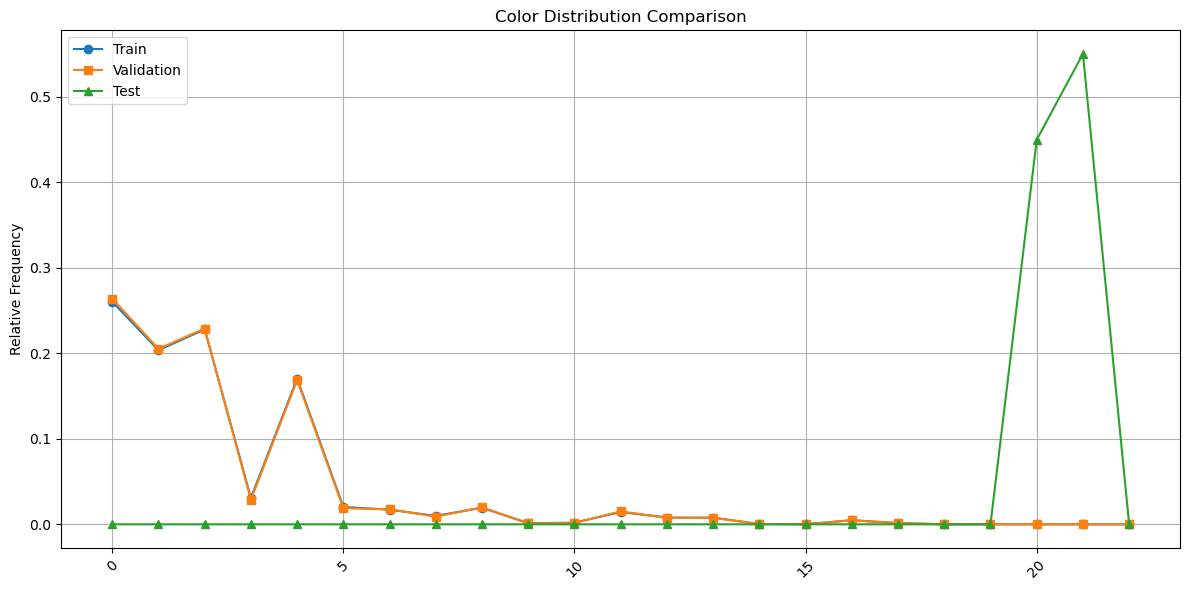

In [40]:
plot_compare_distribution(train_dist=train_no_black_dist, val_dist=val_no_black_dist, test_dist=test_only_black_dist, feature=list(range(lengths["Color"]+1)))

Jensen-Shannon Divergence: 0.12441396285971798
KL-Divergence: 0.06320221328436278


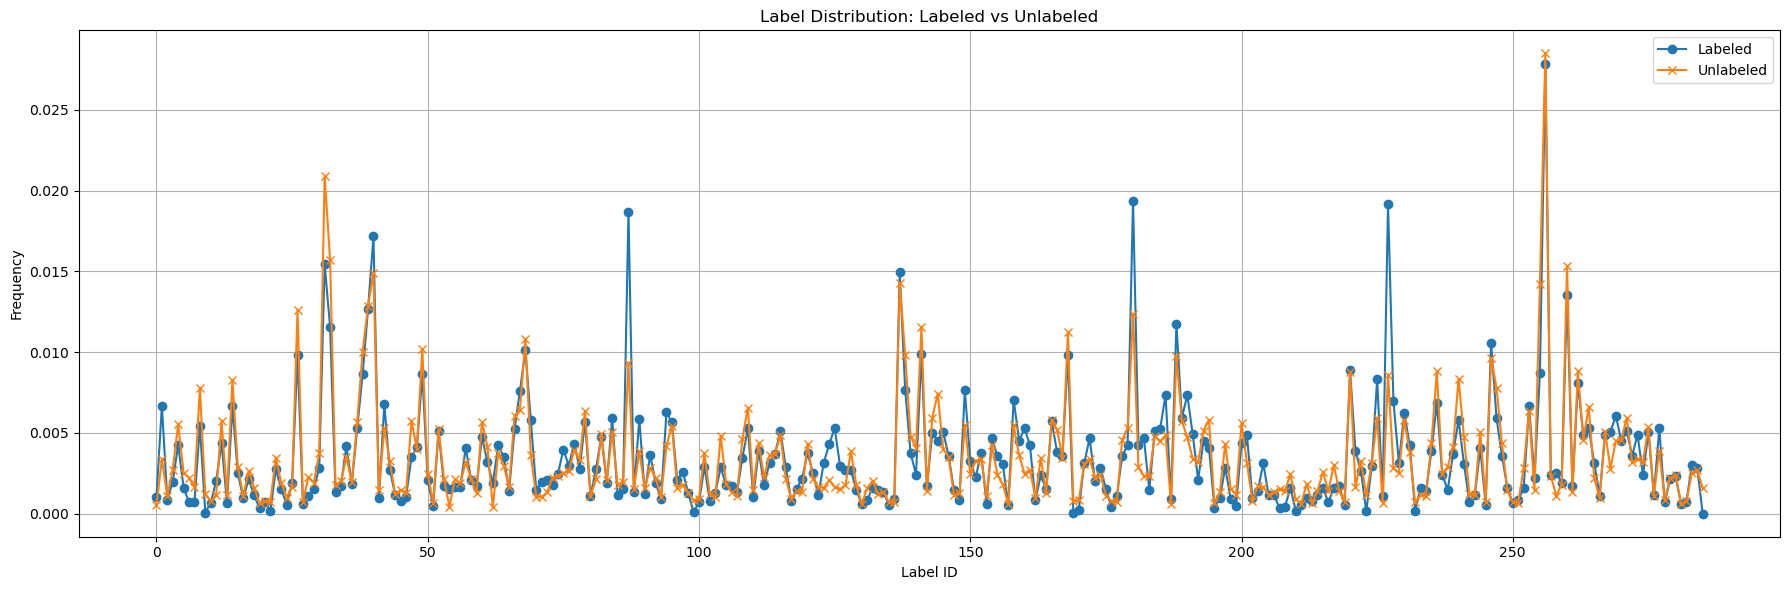

In [52]:
all_lables_path = os.path.join(SHIFTED_DIR, "labels_only_black_train.pt")
all_unlables_path = os.path.join(SHIFTED_DIR, "labels_only_black_test.pt")

label_data = torch.load(all_lables_path, map_location='cpu')

unlabel_data = torch.load(all_unlables_path, map_location='cpu')

from collections import Counter
label_counts = Counter(label_data)
unlabel_counts = Counter(unlabel_data)

# Get sorted list of all label IDs (for alignment)
all_labels = sorted(set(label_counts.keys()) | set(unlabel_counts.keys()))

# Create aligned frequency arrays
label_freqs = np.array([label_counts.get(l, 0) for l in all_labels])
unlabel_freqs = np.array([unlabel_counts.get(l, 0) for l in all_labels])

label_freqs_norm = label_freqs / label_freqs.sum()
unlabel_freqs_norm = unlabel_freqs / unlabel_freqs.sum()

print(f"Jensen-Shannon Divergence: {jensenshannon(label_freqs_norm, unlabel_freqs_norm)}")
print(f"KL-Divergence: {sum(kl_div(label_freqs_norm, unlabel_freqs_norm))}")


plt.figure(figsize=(18, 6))
plt.plot(all_labels, label_freqs_norm, label="Labeled", marker='o')
plt.plot(all_labels, unlabel_freqs_norm, label="Unlabeled", marker='x')
plt.title("Label Distribution: Labeled vs Unlabeled")
plt.xlabel("Label ID")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()